# Linear Classifiers for Image Classification

Neural networks are the algorithms behind "deep learning": the technology at the forefront of current machine learning research. They have proven particularly adept at image and text recognition tasks, and many of you are already very familiar with their applications, which include the likes of Siri, Google Images, AlphaGo and Facebook's photo recognition. Linear classifiers are a substructure of a neural network and are key to understanding the theory of a neural network - here, we demonstrate the use of a linear classifier for image classification. As illustrated below, once you understand a linear classifier (on the left), a neural network (on the right) is simply parallelism and recursion!

<img src="../images/neuralnet.png" alt="Drawing" style="width: 700px; "/>

The code below is for compatibility with Python 2. If you are using Python 3 (recommended), you may ignore this.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

TensorFlow is a machine learning library developed by Google in 2015, TensorFlow is used for easy manipulation of matrices, and their multidimensional generalizations, tensors. Below, we import the TensorFlow package and use the alias `tf` to avoid having to type out the full name every time.

In [3]:
import tensorflow as tf

This is a helper function that will allow us to load training data. Recall that in machine learning, we require labeled data for the algorithm to learn from - we will be using the CIFAR-10 dataset, which is a collection of 32x32 images from 10 different classes collected by researchers at the University of Toronto.

In [4]:
import sys

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        if sys.version[0] == '2':
            dict = pickle.load(fo)
        elif sys.version[0] == '3':
            dict = pickle.load(fo, encoding='bytes')
    return dict

dataset = unpickle('../data/cifar-10-data')

How is image data stored? While we have the ability to look at an image and intuitively judge its content, all a computer sees is pixel data: what colours are present in what locations of the image. For a coloured image, the colour at each pixel is specified by 3 different values: the intensity of the Red, Green & Blue colour channels. Since we are dealing with 32x32 images, this means that we can represent each image using 32x32x3 = 3072 numbers. We can store this as a vector of length 3072, and so our dataset is a matrix with 10000 rows and 3072 columns (one row for each image).

In [5]:
dataset[b'data'].shape

(10000, 3072)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

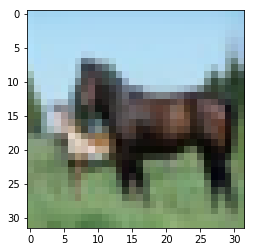

In [7]:
# pick a random number between 0 and 9999
sample = 12
img = dataset[b'data'][sample].reshape(3,32,32).transpose(1,2,0)
plt.imshow(img);

As mentioned previously, for our model to "learn" the trends in a dataset, it must be provided with labels (i.e. the observed "truth"). These are the first 100 labels for the CIFAR-10 dataset: they are stored as a list of numbers between 0 and 9 - what does this mean? Since there are 10 different classes, each number corresponds to a different class.

In [8]:
print(dataset[b'labels'][:100])

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1]


In [9]:
label_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
label_names[dataset[b'labels'][sample]]

'horse'

In [10]:
input_length = 3072
num_classes = 10

Although it makes sense to store each label as one number, where each number between 0 and 9 corresponds to one of the 10 classes, it does not make sense to use these numbers as the targets for our predictions. This is because the relationship between the numerical values does not reflect the relationship between the classes - for example, if we are using the number 2 to denote a bird and 4 to denote a deer, we are implying that 2\*bird = deer, which does not make sense. To fix this, we use one-hot encoding: instead of storing each label as a single number, we store each label as a vector of length equal to the number of classes, and place a 1 in the index corresponding to the true label, and 0s everywhere else. This captures the fact that the 10 classes are mutually exclusive, and can also be interpreted as a probability distribution.   

In [11]:
# We use numpy to do simple operations on arrays
import numpy as np

In [12]:
labels = np.array(dataset[b'labels'])

# since all values are exactly 0 or 1, we do not need floating point accuracy 
# hence the .astype(int)
encoded_labels = np.zeros((10000, num_classes)).astype(int)
encoded_labels[np.arange(10000), labels] = 1

In the example below, we see that the label 7 has been converted into a vector with a 1 in the 7th index (note that arrays in Python are 0-indexed) and 0s everywhere else. Our list of labels is now a matrix of labels, with each row corresponding to the one-hot encoded label of an image.

In [13]:
print(labels[sample])          # the label of our sample image in its original format
print(encoded_labels[sample])  # the label of our sample image in one-hot encoded format

7
[0 0 0 0 0 0 0 1 0 0]


Here, we set up the framework of our machine learning algorithm, which will be a linear classifier. We use $x$ and $y$ to denote our training data: $x$ is a vector of length 3072 representing an image, and $y$ is a vector of length 10 representing the one-hot encoded label. In TensorFlow, we define all the operations we will need to conduct first, before actually doing any computation, so we define these as a `placeholder` into which we will feed the training data.  
     
The key idea behind a linear classifier is that we are using a linear function, the dot product, to measure the similarity between any vector (representing an image) and a series of abstract quality vectors learned by our model. Each of these abstract quality vectors will represent one class, and so intuitively, we have vectors that serve as templates or prototypes of what a horse or a ship looks like, and we are comparing our images to them. The dot product then gives a measure of the "horse-ness" or "ship-ness" of an image - we conduct this comparison for each of the 10 classes, and return our prediction as the one with the highest similarity score. From the thousands of images we provide the model, it learns what birds or frogs generally "look" like. To generate its predictions, we can conduct several dot products in parallel using matrix multiplication and find the class with the highest score.

Another way to think about this is that we are taking a weighted sum of all the pixel values so that the output vector has high values in the index corresponding to the true class, and low values everywhere else. Mathematically, this means that we are generating a "scores" vector of length 10 by taking $s = Wx + b$. We include the bias term $b$ so that our scores do not have to be 0 when our inputs are 0. To make the dimensions of matrix multiplication valid, we need $W$ to be a matrix with 10 rows and 3072 columns, and $b$ to be a vector of length 10. We declare these as a `Variable` in TensorFlow, as we will optimize these quantities so that our model outputs our desired scores.

In [14]:
# When creating placeholders, we specify the data type, the tensor's shape 
# (None indicates it may vary), and a name
x = tf.placeholder(tf.float32, [None, input_length], name='x')
y = tf.placeholder(tf.int64, [None, num_classes], name='y')

# When creating variables, we specify how to initialize them: 
# tf.truncated_normal() uses a normal distribution
W = tf.Variable(tf.truncated_normal([input_length, num_classes]), name='W')
b = tf.Variable(tf.truncated_normal([num_classes]), name='b')

As stated above, we define our scores vector to be $Wx + b$. However, these scores can be difficult to interpret and manipulate - while a high score indicates our model having a stronger belief that the image belongs to a certain class, it is difficult to interpret the values of these scores and determine how large a score is sufficient to say that our model is "good". We therefore use the softmax function (see more details [here](https://en.wikipedia.org/wiki/Softmax_function)) to compress each value of the scores vector into a value bewteen 0 and 1 such that the sum of the vector is equal to 1. This puts our predictions on a similar scale to our one-hot encoded labels, and once again gives us a probabilistic interpretation - now we have a concrete idea of how large a score is large enough, because a 100% probability signifies absolute certainty.  
  
You may have noticed that we haven't quantitatively defined what it means for a model to be "good". Now that we have generated prediction vectors $\hat{y} = \sigma(Wx = b)$, we can use some measure of the difference between $y$ and $\hat{y}$ as a measure of how well our model is performing. Here, we use the cross-entropy loss function, which quantifies the difference between two probability distributions - the smaller the value, the smaller the difference and therefore the better our model. We have now reduced the problem of image classification to the minimization of this loss function!

In [16]:
scores = tf.matmul(x, W) + b
pred = tf.nn.softmax(scores)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=scores))

We will also want to keep track of some more conventional measures, such as accuracy (the fraction of images which we classify correctly). We do so by counting the number of times that the index with highest value in $\hat{y}$ matches the index with highest value in $y$. While this is a valuable measure of performance, the reason why we do not select this as the quantity we want to optimize is because it is not differentiable - differentiability is a necessary property of the optimization techniques we will be using to find optimal values of $W$ and $b$.

In [17]:
correct = tf.equal(tf.argmax(pred, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

The technique we are using to minimize our loss function is called gradient descent - it is an iterative method that starts from a random position on your function, and takes "steps" in the direction that the function decreases fastest until we reach the minimum. A common analogy used to describe this is a situation where you are stranded on a hill in the middle of the night and you are trying to reach the bottom. Since you are unable to see around you, you feel the slope of the hill beneath your feet and take a step in the direction that slopes down the steepest. With some basic assumptions about the shape of your hill, this approach will eventually get you to the bottom. Mathematically, we calculate the gradient of our loss function to find the direction of steepest descent, and continually take steps in that direction, updating the gradient every time we move. The size of the step we take, referred to as the learning rate, is a quantity that we must decide on beforehand.

In [18]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
init = tf.global_variables_initializer()   # initialize all variable tensors

Here, we split our data into "batches" so that our model can learn from multiple images at at time instead of just one.

In [19]:
training = dataset[b'data']
n_batches = 20
x_train = np.array_split(training, n_batches)
y_train = np.array_split(encoded_labels, n_batches)
n_epochs = 100

This is the stage in which our model is learning the trends in the data. We pass the entire dataset into our model, one batch at a time, so that the parameters $W$ and $b$ are optimized so as to minimize the loss function. This gives us values of $W$ and $b$ such that $\hat{y}$ and $y$ are similar, and therefore our model is able to approximate the "truth" that we provided it with. Here, it is important to note that the accuracy displayed is training accuracy: the accuracy of the model on data that it has already seen. For a model to be useful in the real world it must generalize to data that it has not seen, and in most cases we will find that testing performance is worse than training performance.

In [20]:
sess = tf.InteractiveSession()

In [21]:
sess.run(init)
for j in range(n_epochs):
    total_loss = 0
    total_accuracy = 0
    for i in range(n_batches):
        results = sess.run([optimizer, loss, accuracy], feed_dict={x:x_train[i], y:y_train[i]})
        total_loss += results[1]
        total_accuracy += results[2]
    if j%10 == 9:
        print('epoch {:3}: loss={:6} accuracy={:.4f}'
              .format(j+1, int(total_loss/n_batches), total_accuracy/n_batches))

epoch  10: loss= 67852 accuracy=0.2061
epoch  20: loss= 62018 accuracy=0.2365
epoch  30: loss= 69462 accuracy=0.2219
epoch  40: loss= 56441 accuracy=0.2634
epoch  50: loss= 62457 accuracy=0.2405
epoch  60: loss= 56903 accuracy=0.2498
epoch  70: loss= 60770 accuracy=0.2524
epoch  80: loss= 47889 accuracy=0.2717
epoch  90: loss= 59200 accuracy=0.2523
epoch 100: loss= 49121 accuracy=0.2730


Although this model is far from current state-of-the-art, it is still able to make useful inferences about what is contained in an image. Below, we see that our linear classifier is able to correctly able to identify that a given image is one of a horse!

Prediction: deer


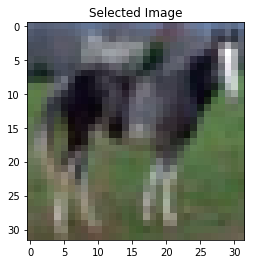

In [23]:
sample = 37
image = training[sample]
plt.imshow(image.reshape(3,32,32).transpose(1,2,0));
plt.title('Selected Image')

print('Prediction:', label_names[sess.run(tf.argmax(pred, axis=1), feed_dict={x:[image]})[0]])